# Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться.    
Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.      
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.   
Будем работать над решением, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.    

# Как будет выполняться проект

Решение задачи будет проведено в два этапа:   
Разработка модели, которая предскажет вероятность снижения покупательской активности.   
Выделение сегмента покупателей, его анализ и предложение, как увеличить его покупательскую активность.   

# 1. Загрузка данных

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import plotly.express as px
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from phik import phik_matrix

#Постоянная переменная
RANDOM_STATE = 1131


In [3]:
#activity = pd.read_csv(r'D:\Data Science\Практикум\Проекты\2 Заход\Датасеты\Обучение с учителем\market_file.csv', sep=',')
#revenue = pd.read_csv(r'D:\Data Science\Практикум\Проекты\2 Заход\Датасеты\Обучение с учителем\market_money.csv', sep=',')
#time = pd.read_csv(r'D:\Data Science\Практикум\Проекты\2 Заход\Датасеты\Обучение с учителем\market_time.csv', sep=',')
#money = pd.read_csv(r'D:\Data Science\Практикум\Проекты\2 Заход\Датасеты\Обучение с учителем\money.csv', sep=';')


activity = pd.read_csv(r'D:\D_S\Project\2\datasets\Обучение с учителем\market_file.csv', sep=',')
revenue = pd.read_csv(r'D:\D_S\Project\2\datasets\Обучение с учителем\market_money.csv', sep=',')
time = pd.read_csv(r'D:\D_S\Project\2\datasets\Обучение с учителем\market_time.csv', sep=',')
money = pd.read_csv(r'D:\D_S\Project\2\datasets\Обучение с учителем\money.csv', sep=';')

## Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [4]:
activity.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


- id — номер покупателя в корпоративной базе данных.   
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».   
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».   
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.   
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.   
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.   
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.   
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.   
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.   
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.   
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.   
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.   
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.   

## Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [5]:
revenue.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

## Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [6]:
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

## Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [7]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

# 2. Предобработка данных

## Предобработка столбцов

In [8]:
def columns_to_remove(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [9]:
columns_to_remove(activity)
columns_to_remove(revenue)
columns_to_remove(time)
columns_to_remove(money)

### Предобработка в revenue

In [10]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [11]:
activity.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


In [12]:
activity.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [13]:
activity.duplicated().sum()

np.int64(0)

In [14]:
activity.nunique()

id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

In [15]:
activity['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

В датасете - активность покупателей нет дубликатов и пропусков, однако я нашел 1 неочивидный дубликат.

In [16]:
activity['тип_сервиса'] = activity['тип_сервиса'].replace('стандартт', 'стандарт')

In [17]:
activity['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

### Предобработка в revenue

In [18]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [19]:
revenue.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [20]:
revenue.nunique()

id         1300
период        3
выручка    2776
dtype: int64

In [21]:
revenue['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [22]:
#revenue['Период'] = revenue['Период'].replace('препредыдущий_месяц', 'предыдущий_месяц')

In [23]:
revenue.duplicated().sum()

np.int64(0)

In [24]:
#revenue = revenue.drop_duplicates().reset_index(drop=True)

In [25]:
revenue.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [26]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В столбце Период есть 3 значения:   
- 'препредыдущий_месяц',    
- 'текущий_месяц',    
- 'предыдущий_месяц'   
Посколько они распределены равномерно, по 33.33%, по 1300 значений. Я принял решение, что 'препредыдущий_месяц', это не дубликат, месяц перед предыдущим, оставляю его.   

### Предобработка в time

In [27]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [28]:
time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [29]:
time.nunique()

id        1300
период       2
минут       20
dtype: int64

In [30]:
time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [31]:
time['период'] = time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [32]:
time.duplicated().sum()

np.int64(0)

In [33]:
time.isna().sum()

id        0
период    0
минут     0
dtype: int64

Исправил ошибку 'предыдцщий_месяц' на 'предыдущий_месяц'

### Предобработка в money

In [34]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [35]:
money['прибыль'] = pd.to_numeric(money['прибыль'].str.replace(',', '.'), errors='coerce')

In [36]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [37]:
money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


In [38]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Изменил тип данных в столбце 'Прибыль' с object на float64

# 3. Исследовательский анализ данных

In [39]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

### Рассмотрим целевую переменнную 

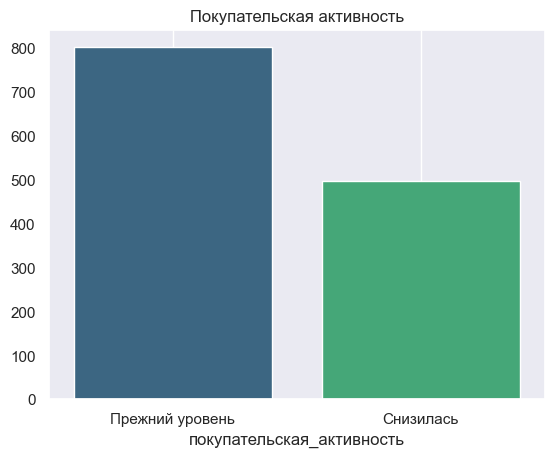

In [40]:
sns.barplot(x=activity['покупательская_активность'].value_counts().index,
            y=activity['покупательская_активность'].value_counts().values,
            hue=activity['покупательская_активность'].value_counts().index,
            palette='viridis')
plt.title('Покупательская активность')
plt.grid()
plt.show()

In [41]:
activity['покупательская_активность'].value_counts(normalize=True).mul(100)

покупательская_активность
Прежний уровень    61.692308
Снизилась          38.307692
Name: proportion, dtype: float64

Имеем дисбаланс классов, при разбиении на выборки будем применять стратификацию.

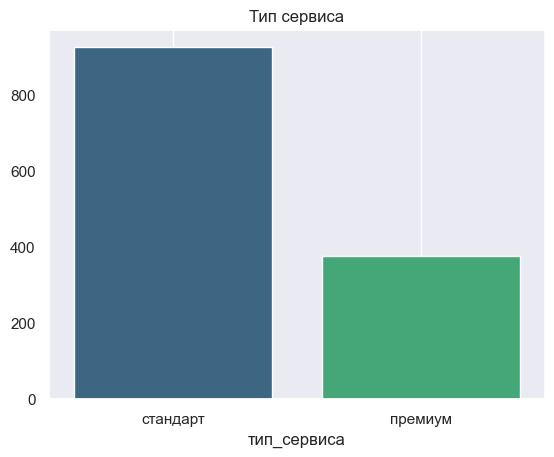

In [42]:
sns.barplot(x=activity['тип_сервиса'].value_counts().index,
            y=activity['тип_сервиса'].value_counts().values,
            hue=activity['тип_сервиса'].value_counts().index,
            palette='viridis')
plt.title('Тип сервиса')
plt.grid()
plt.show()

In [43]:
activity['тип_сервиса'].value_counts(normalize=True).mul(100)

тип_сервиса
стандарт    71.076923
премиум     28.923077
Name: proportion, dtype: float64

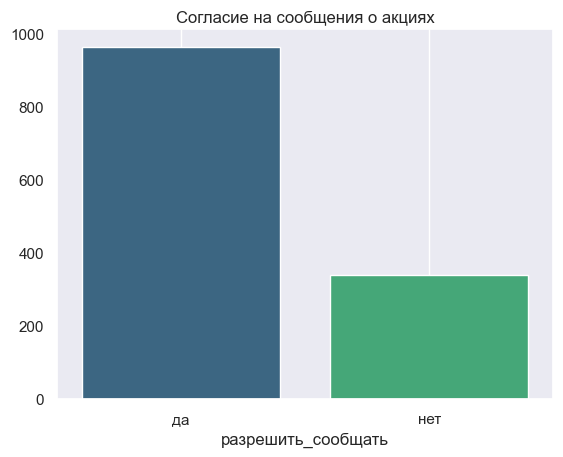

In [44]:
sns.barplot(x=activity['разрешить_сообщать'].value_counts().index,
            y=activity['разрешить_сообщать'].value_counts().values,
            hue=activity['разрешить_сообщать'].value_counts().index,
            palette='viridis')
plt.title('Согласие на сообщения о акциях')
plt.grid()
plt.show()

In [45]:
activity['разрешить_сообщать'].value_counts(normalize=True).mul(100)

разрешить_сообщать
да     74.0
нет    26.0
Name: proportion, dtype: float64

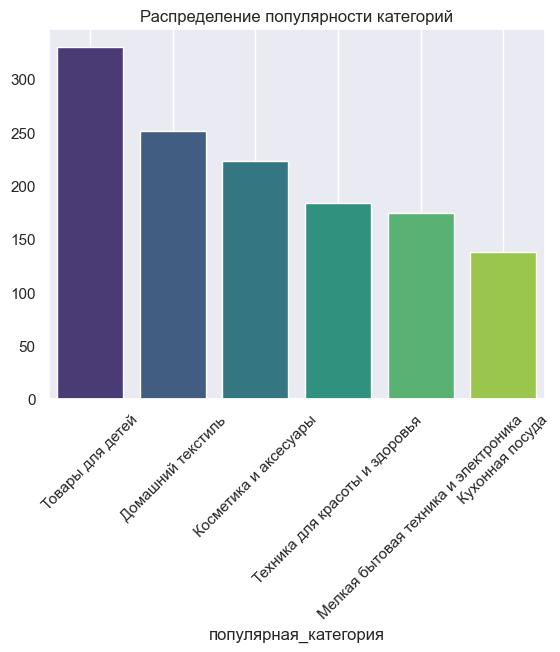

In [46]:
sns.barplot(x=activity['популярная_категория'].value_counts().index,
            y=activity['популярная_категория'].value_counts().values,
            hue=activity['популярная_категория'].value_counts().index,
            palette='viridis')
plt.title('Распределение популярности категорий')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [47]:
activity['популярная_категория'].value_counts(normalize=True).mul(100)

популярная_категория
Товары для детей                        25.384615
Домашний текстиль                       19.307692
Косметика и аксесуары                   17.153846
Техника для красоты и здоровья          14.153846
Мелкая бытовая техника и электроника    13.384615
Кухонная посуда                         10.615385
Name: proportion, dtype: float64

In [48]:
fig = px.histogram(
    activity, 
    x='маркет_актив_6_мес', 
    title='Cреднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев',
    labels={'маркет_актив_6_мес': 'Уровень активности', 'count': 'Кол-во клиентов'}, 
            color_discrete_sequence=['purple'],
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=activity['маркет_актив_6_мес'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {activity['маркет_актив_6_мес'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [49]:
fig = px.histogram(
    activity, 
    x='маркет_актив_тек_мес', 
    title='Среднее кол-во коммуникаций за месяц',
    labels={'маркет_актив_тек_мес': 'Кол-во коммуникаций', 'count': 'Кол-во раз'}, 
            color_discrete_sequence=['blue'],
            opacity=0.9,
            nbins=10,
            text_auto=True)
fig.show()

In [50]:
fig = px.histogram(
    activity, 
    x='длительность', 
    title='Сколько дней прошло с момента регистрации покупателя на сайте',
    labels={'длительность': 'Сколько дней', 'count': 'Кол-во раз'}, 
            color_discrete_sequence=['pink'],
            opacity=1,
            nbins=50,
            marginal='box',
            text_auto=True)
fig.add_vline(x=activity['длительность'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {activity['длительность'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [51]:
fig = px.histogram(
    activity, 
    x='акционные_покупки', 
    title='Cреднемесячная доля покупок по акции от общего числа покупок',
    labels={'акционные_покупки': 'Покупок', 'count': 'Кол-во раз'}, 
            color_discrete_sequence=['green'],
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=activity['акционные_покупки'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {activity['акционные_покупки'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [52]:
fig = px.histogram(
    activity, 
    x='средний_просмотр_категорий_за_визит', 
    title='Cколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.',
    labels={'средний_просмотр_категорий_за_визит': 'Средний_просмотр_категорий_за_визит', 'count': 'Кол-во раз'}, 
            color_discrete_sequence=['cyan'],
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=activity['средний_просмотр_категорий_за_визит'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {activity['средний_просмотр_категорий_за_визит'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [53]:
fig = px.histogram(
    activity, 
    x='неоплаченные_продукты_штук_квартал', 
    title='Cколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.',
    labels={'Неоплаченеоплаченные_продукты_штук_кварталнные_продукты_штук_квартал': 'Неоплаченные_продукты_штук_квартал', 'count': 'Кол-во раз'}, 
            color_discrete_sequence=['black'],
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=activity['неоплаченные_продукты_штук_квартал'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {activity['неоплаченные_продукты_штук_квартал'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [54]:
fig = px.histogram(
    activity, 
    x='ошибка_сервиса', 
    title='Число сбоев, которые коснулись покупателя во время посещения сайта.',
    labels={'ошибка_сервиса': 'Ошибка_сервиса', 'count': 'Кол-во раз'}, 
            color_discrete_sequence=['brown'],
            opacity=0.9,
            nbins=15,
            marginal='box',
            text_auto=True)
fig.add_vline(x=activity['ошибка_сервиса'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {activity['ошибка_сервиса'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [55]:
fig = px.histogram(
    activity, 
    x='страниц_за_визит', 
    title='Cреднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.',
    labels={'страниц_за_визит': 'страниц_за_визит', 'count': 'Кол-во раз'}, 
            color_discrete_sequence=['yellow'],
            opacity=0.9,
            nbins=15,
            marginal='box',
            text_auto=True)
fig.add_vline(x=activity['страниц_за_визит'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {activity['страниц_за_визит'].mean():.2f}', 
              annotation_position='top')
fig.show()

## Посмотрим теперь на датасет revenue

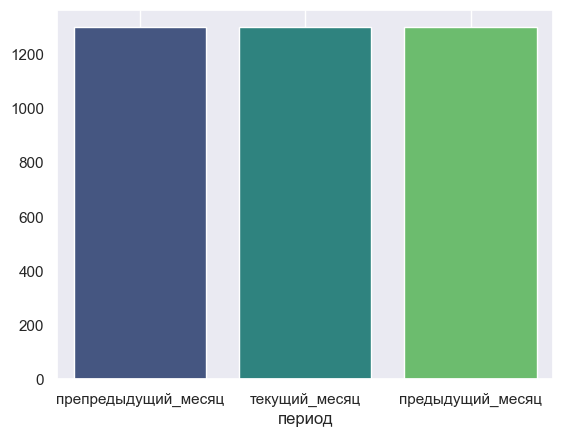

In [56]:
sns.barplot(
    x=revenue['период'].value_counts().index,
    y=revenue['период'].value_counts().values,
    hue=revenue['период'].value_counts().index,
    palette='viridis',
    legend=False
)
plt.grid()

In [57]:
revenue['период'].value_counts()

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [58]:
fig = px.histogram(
    revenue, 
    x='выручка', 
    title='Сумма выручки за период.',
    labels={'выручка': 'Выручка', 'count': 'Кол-во раз'},
            opacity=0.9,
            nbins=10,
            marginal='box',
            text_auto=True)
fig.add_vline(x=revenue['выручка'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {revenue['выручка'].mean():.2f}', 
              annotation_position='top')
fig.show()

Есть выброс, выручка в 100к

In [59]:
revenue[revenue['выручка'] > 8000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [60]:
revenue['выручка'] = revenue[revenue['выручка'] < 8000]['выручка'].reset_index(drop=True)

## Еще раз взглянем на график

In [61]:
fig = px.histogram(
    revenue, 
    x='выручка', 
    title='Сумма выручки за период.',
    labels={'Выручка': 'Выручка', 'count': 'Кол-во раз'},
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=revenue['выручка'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {revenue['выручка'].mean():.2f}', 
              annotation_position='top')
fig.show()

## Теперь у нас появились пару аномальных значений - сумма = 0, 3 строки. Принимаю решение от них тоже избавиться.

In [62]:
revenue.drop(revenue[revenue['выручка'] == 0.0].index, inplace=True)
revenue.reset_index(drop=True, inplace=True)

## Посмотрим теперь на датасет time

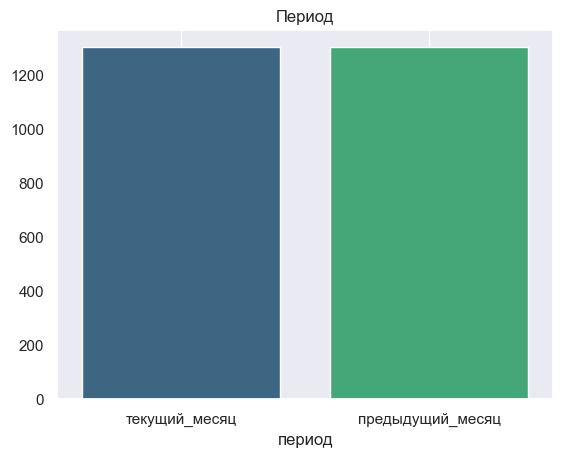

In [63]:
sns.barplot(
    x=time['период'].value_counts().index,
    y=time['период'].value_counts().values,
    hue=time['период'].value_counts().index,
    palette='viridis'
)
plt.title('Период')
plt.grid() 
plt.show()

In [64]:
fig = px.histogram(
    time, 
    x='минут', 
    title='Значение времени, проведённого на сайте, в минутах.',
    labels={'минут': 'минут', 'count': 'Кол-во раз'},
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=time['минут'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {time['минут'].mean():.2f}', 
              annotation_position='top')
fig.show()

# Остался датасет money

In [65]:
fig = px.histogram(
    money, 
    x='прибыль', 
    title='Значение времени, проведённого на сайте, в минутах.',
    labels={'прибыль': 'Прибыль', 'count': 'Кол-во раз'},
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=money['прибыль'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {money['прибыль'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [66]:
money[money['прибыль'] > 7]

,id,прибыль
53,215401,7.43
817,216165,7.02
1026,216374,7.21


In [67]:
money[money['прибыль'] < 1]

,id,прибыль
0,215348,0.98
774,216122,0.86
976,216324,0.86


Есть 6 выбивающихся значений, думаю стоит удалить их

In [68]:
money.drop(money[money['прибыль'] > 7 ].index, inplace=True)
money.drop(money[money['прибыль'] < 1 ].index, inplace=True)
money.reset_index(drop=True, inplace=True)

# Посмотрим на изменения

In [69]:
fig = px.histogram(
    money, 
    x='прибыль', 
    title='Значение времени, проведённого на сайте, в минутах.',
    labels={'прибыль': 'Прибыль', 'count': 'Кол-во раз'},
            opacity=0.9,
            nbins=20,
            marginal='box',
            text_auto=True)
fig.add_vline(x=money['прибыль'].mean(), line_dash='dash', line_color='red', 
              annotation_text=f'Среднее: {money['прибыль'].mean():.2f}', 
              annotation_position='top')
fig.show()

In [70]:
activity['акционные_покупки_категория'] = activity['акционные_покупки']\
.apply( lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' )
activity = activity.drop(['акционные_покупки'], axis=1)

# Вывод исследовательского анализа: 
- 61% покупателей сохранили прежнюю активность   
- 71% использует стандартный тип сервиса   
- 74% разрешает сообщать дополнительные предложения о товаре   
- Тройка лидеров в популярных категориях: 
  1. Товары для детей
  2. Домашний текстиль
  3. Косметика и аксесуары
- В датасете time есть данные за предыдущий и текущий месяц по ровну по 1300, в revenue же дела обстоят так - за текущий месяц 1300 записей, а за предыдущий 2595 
- В датасете revenue в столбце выручка есть одно выбивающееся значение - 106862.2, удалил его, так как оно может помешать обучению модели. 
- В датасете money удалил 6 строк с выручкой менее 1 - 3 строки и более 7 - 3 строки.

# 4. Объединение таблиц

In [71]:
print('Activity:', activity.columns, sep='\n')
print()
print('Revenue:', revenue.columns, sep='\n')
print()
print('Time:', time.columns, sep='\n')

Activity:
Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'популярная_категория', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'акционные_покупки_категория'],
      dtype='object')

Revenue:
Index(['id', 'период', 'выручка'], dtype='object')

Time:
Index(['id', 'период', 'минут'], dtype='object')


In [72]:
revenue_pivot = revenue.pivot(index='id', columns='период', values='выручка').add_prefix('выручка_')

time_pivot = time.pivot(index='id', columns='период', values='минут').add_prefix('минут_')
df = (activity
      .merge(revenue_pivot, on='id', how='left')
      .merge(time_pivot, on='id', how='left'))

In [73]:
df

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категория,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,Товары для детей,6,2,1,5,Редко покупает по акции,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,Товары для детей,4,4,2,5,Часто покупает по акции,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,Домашний текстиль,5,2,1,5,Редко покупает по акции,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,Товары для детей,5,0,6,4,Часто покупает по акции,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,Товары для детей,3,2,3,2,Часто покупает по акции,5807.5,4594.0,5872.5,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,Техника для красоты и здоровья,5,3,3,11,Редко покупает по акции,4741.7,3664.0,4729.0,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,Домашний текстиль,6,2,3,9,Редко покупает по акции,5353.0,5160.0,5299.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,Домашний текстиль,3,2,5,7,Редко покупает по акции,5139.2,5224.6,5334.0,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,Техника для красоты и здоровья,3,3,5,7,Редко покупает по акции,4720.0,4923.0,4725.0,18,7


In [74]:
df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категория,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,Товары для детей,6,2,1,5,Редко покупает по акции,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,Товары для детей,4,4,2,5,Часто покупает по акции,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,Домашний текстиль,5,2,1,5,Редко покупает по акции,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,Товары для детей,5,0,6,4,Часто покупает по акции,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,Товары для детей,3,2,3,2,Часто покупает по акции,5807.5,4594.0,5872.5,8,11


In [75]:
df.duplicated().sum()

np.int64(0)

In [76]:
df.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
акционные_покупки_категория            0
выручка_предыдущий_месяц               3
выручка_препредыдущий_месяц            3
выручка_текущий_месяц                  1
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [77]:
df.dropna(subset=['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'], inplace=True)

In [78]:
df.sample(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категория,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1007,216355,Прежний уровень,стандарт,да,5.1,4,433,Товары для детей,4,1,4,9,Редко покупает по акции,4796.7,4005.0,5542.5,20,5
1167,216515,Прежний уровень,стандарт,да,4.9,4,882,Косметика и аксесуары,3,2,6,9,Редко покупает по акции,4761.0,5624.6,5007.0,16,19
1067,216415,Прежний уровень,стандарт,да,4.7,4,536,Домашний текстиль,6,3,4,11,Редко покупает по акции,5191.8,4803.5,4604.0,12,20
1145,216493,Прежний уровень,стандарт,да,5.3,4,129,Домашний текстиль,4,5,2,17,Редко покупает по акции,4944.0,4820.5,5371.5,16,9
1074,216422,Прежний уровень,стандарт,да,5.2,5,726,Мелкая бытовая техника и электроника,4,5,6,12,Редко покупает по акции,4654.0,4519.0,4988.5,15,17


## Промежуточный вывод:
- Объеденили 3 датафрейма в 1 для обучения на нем различных моделей 
- Удалил пропуски в столбцах 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'

# 5. Корреляционный анализ

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


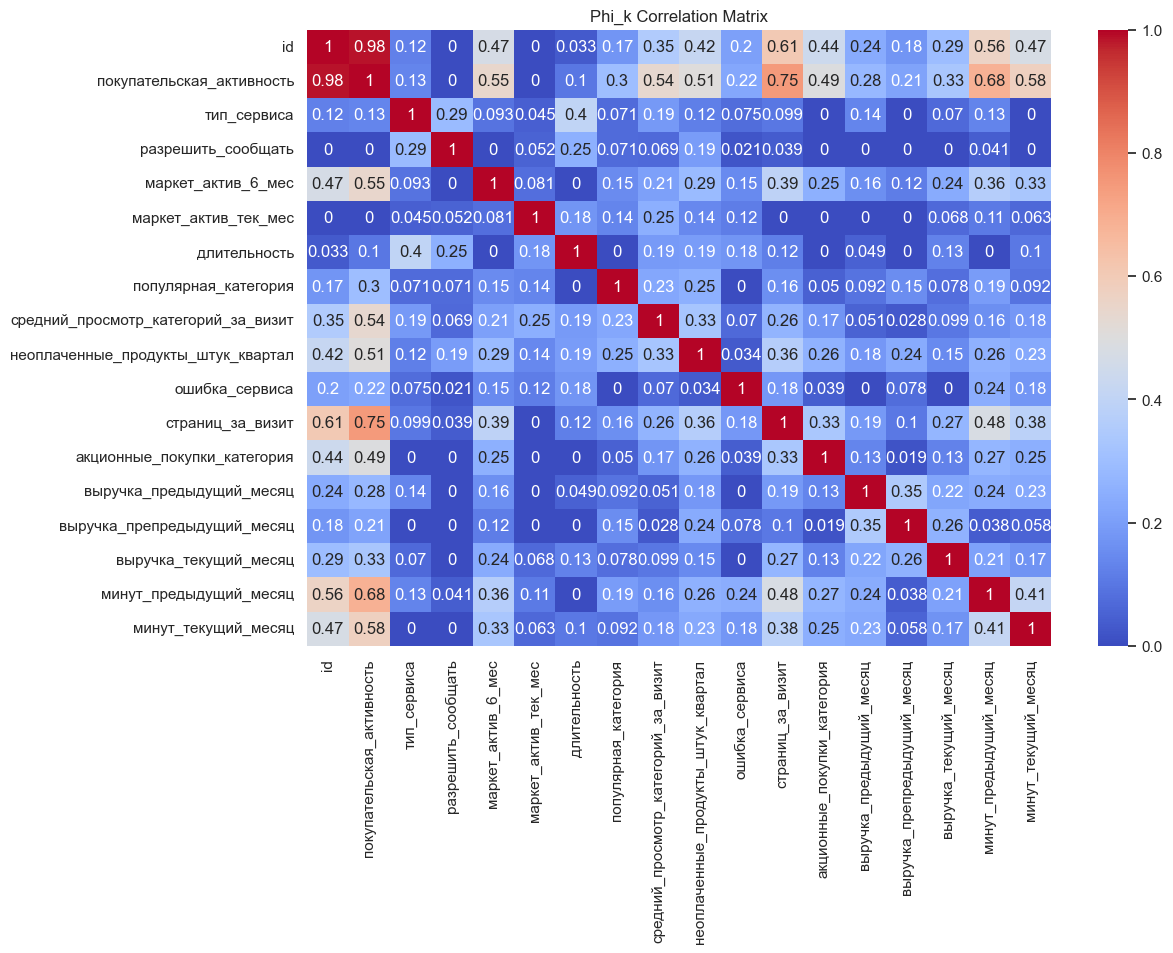

In [79]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.phik_matrix(), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Phi_k Correlation Matrix')
plt.show()

## Промежуточный вывод: 
Покупательская активность сильно коррелирует с столбцом Страниц за визит. Оно и понятно, когда пользователь активен, он точно пролистает несколько страниц, также коррелирует с кол-вом минут, проведенных на сайте и активность за последние 6 месяцев.    


# 6. Использование пайплайнов

Разделим данные на выборки

In [80]:
df['покупательская_активность'].value_counts()

покупательская_активность
Прежний уровень    801
Снизилась          495
Name: count, dtype: int64

Есть дисбаланс в целевой переменной, поэтому используем стратификацию

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['id', 'покупательская_активность'], axis=1),
    df['покупательская_активность'],
    test_size=.25,
    random_state=RANDOM_STATE,
    stratify=df['покупательская_активность']
    )

In [82]:
X_train.shape, X_test.shape

((972, 16), (324, 16))

## Закодируем целевой признак

In [83]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [84]:
print('Закодированные значения:', y_train[:2])
print('Соответстующие категории:', label_encoder.classes_)

Закодированные значения: [0 1]
Соответстующие категории: ['Прежний уровень' 'Снизилась']


Выделим столбцы для кодирования

In [85]:
X_train.head(1)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категория,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1086,премиум,да,5.3,3,724,Косметика и аксесуары,1,1,6,9,Редко покупает по акции,6111.8,4822.5,4470.0,16,17


In [86]:
ohe_columns = [
    'популярная_категория', 
    'разрешить_сообщать',
    'акционные_покупки_категория'
    ] 
ord_columns = [
    'тип_сервиса'
    #'Период_выручки',
    #'Период_времени'
    ]
num_columns = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит',
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_текущий_месяц',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'
    ]

Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование   
SimpleImputer + OHE   

In [87]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
     ]
)

cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование   
SimpleImputer + OE   

In [88]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(
         categories=[
             ['стандарт', 'премиум'],
             #['предыдущий_месяц', 'текущий_месяц'],
             #['предыдущий_месяц', 'текущий_месяц']
             #['нет', 'да']
         ],
         handle_unknown='use_encoded_value', unknown_value=np.nan
     )
     ), 
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     ]
)

Создаём общий пайплайн для подготовки данных

In [89]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

Создаём итоговый пайплайн: подготовка данных и модель

In [90]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [91]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5 ),
        'models__max_features': [0.5, 'sqrt', 'log2'],
        'models__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(8, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': range(2, 5),
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear'
            )],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 11),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [92]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [93]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория',
                                                                                'разрешить_сообщать',
                                                                                'акционные_покуп...
                                        {'models': [SVC(random_state=1131)],
                                         'models__C': range(2, 5),
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(random_state=1131,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 11),
                                         'models__penalty': ['l1', 'l2'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=1131, scoring='roc_auc')

In [94]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать',
                                                   'акционные_покупки_категория']),
        

In [95]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8863306451612903


# Промежуточный вывод:
- Лучше всего себя показала модель LogisticRegression с гиперпараметрами C=1, penalty='l1', solver='liblinear'   
- 'num'= StandardScaler
- Итоговая метрика на тесте = 0.886

# 7. Анализ важности признаков

## Оценим важность признаков для лучшей модели

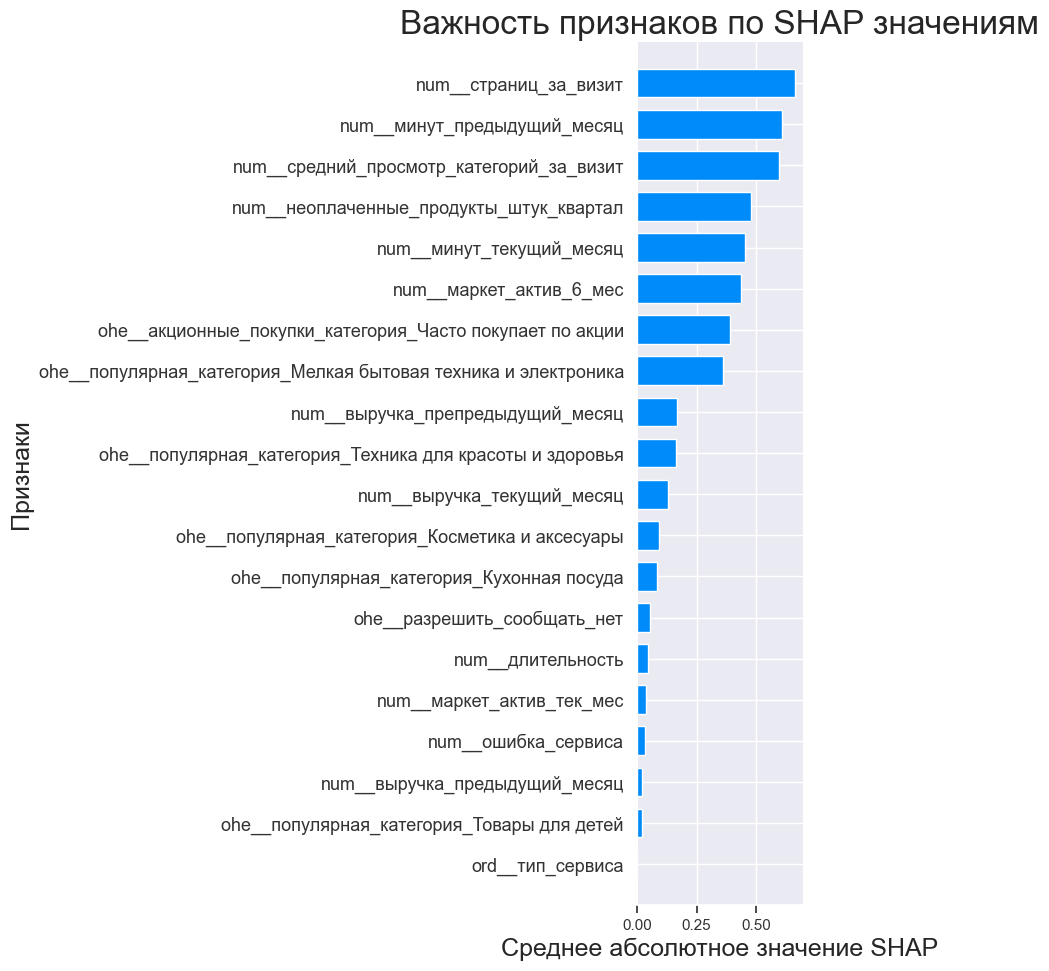

In [96]:
X_transformed = randomized_search.best_estimator_['preprocessor'].fit_transform(X_train)

# Обучаем на лучших моделях из грида закодированные данные
model = randomized_search.best_estimator_['models'].fit(X_transformed, y_train)
feature_names = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()

explainer = shap.LinearExplainer(model, X_transformed)
shap_values = explainer.shap_values(X_transformed)

plt.figure(figsize=(20, 10))

shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names, plot_type="bar", show=False)


plt.title("Важность признаков по SHAP значениям", fontsize=24)
plt.xlabel("Среднее абсолютное значение SHAP", fontsize=18)
plt.ylabel("Признаки", fontsize=18)

plt.show()

## Топ 7 самых важных признаков:   
- Страниц_за_визит, 
- минут в предыдущий месяц,
- Средний просмотр категорий за визит, 
- Неоплаченный_продукты_штук_квартал, 
- минут текущий месяц,
- часто покупает по акции, 
- мелкая бытовая техника и электроника.

Чем больше пролистаешь страниц те больше вероятность что найдешь нужный товар. Кроме того при поиске той самой модели продукта постоянно добавляешь в корзину интересные находки и в итоге покупаешь только что-то одно.
Объяснить это можно, как просмотр reels или tik-tok. Чем дольше проводишь времени и смотришь на яркие вещи, тем больше начинаешь листать в поисках новой, неординарной вещи.

## Малозначимыми признаками оказались:
- Популярная категория(кроме бытовой техники), 
- Маркет_актив_тек_мес, 
- Разрешить сообщать, 
- Тип_сервиса, 
- Выручка_текущий_месяц, 
- Длительность, 
- Ошибка_сервиса, 
- Выручка_предыдущий_месяц. 

## Основываясь на этих данных могу дать несколько реомендаций:
- Работать над улучшением визуала приложения и удобства пользования. Сделать так, чтобы можно было подольше посидеть в нем, разные вкладки, в которые можно провалиться.
- Акцентировать внимание над рекомендательной системой, чтобы даже в том случае, когда клиент просмотрит все товары, которые он искал, лента продолжалась. Превратить поиск нужного товара в скролл побольше.


# 8. Сегментация покупателей

In [97]:
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
y_train_proba = randomized_search.predict_proba(X_train)[:, 1]

X_test_full = X_test.copy()
X_train_full = X_train.copy()

X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba

In [98]:
df['вероятность_снижения'] = pd.concat([X_test_full['вероятность_снижения'], X_train_full['вероятность_снижения']])
df = df.merge(money.set_index('id'), on='id')


In [99]:
df.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категория,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,вероятность_снижения,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,Товары для детей,4,4,2,5,Часто покупает по акции,5216.0,4472.0,4971.6,12,10,0.939662,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,Домашний текстиль,5,2,1,5,Редко покупает по акции,5457.5,4826.0,5058.4,8,13,0.432353,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,Товары для детей,5,0,6,4,Часто покупает по акции,6158.0,4793.0,6610.4,11,13,0.722419,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,Товары для детей,3,2,3,2,Часто покупает по акции,5807.5,4594.0,5872.5,8,11,0.957923,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,Домашний текстиль,4,1,1,4,Редко покупает по акции,4738.5,5124.0,5388.5,10,10,0.721165,3.95


In [100]:
fig = px.scatter(
    df, 
    x='вероятность_снижения', 
    y='прибыль',
    title='Зависимость вероятности снижения от выручки',
    labels={'прибыль': 'Прибыль', 'Вероятность снижения': 'Вероятность снижения'},
    color='прибыль',
    opacity=0.7)
fig.show()

Заметной связи с снижением активности клиента и выручкой не вижу. Клиенты, тратящие разные суммы, одинаково могут перестать пользоваться сервисом

In [101]:
for i in df[df.select_dtypes(include='object').columns].drop('покупательская_активность', axis=1):
    fig = px.scatter(
    df, 
    x='вероятность_снижения', 
    y='прибыль',
    title=f'Зависимость вероятности снижения от ({i})',
    labels={'прибыль': 'Прибыль', 'Вероятность снижения': 'Вероятность снижения', i: i},
    color=i,
    hover_data=['вероятность_снижения', 'прибыль', i],
    opacity=0.7)
    fig.show()

### Могу наблюдать на графиках, что :   
- клиенты, которые часто покупают товары категории - Мелкая бытовая техника и электроника, имеют меньшую вероятность снижения активности.   
- клиенты, которые редко покупают по акции, намного реже снижают активность, а те, кто часто покупают товары по акции снижают свою активность.   
Могу предположить, что такие люди сравнивают стоимость на разных ресурсах и подбирают для себя самое выгодное предложение.         

## На основе этого выделим сегмент покупателей:
если вероятность снижения активности покупателя выше 80% и он часто покупает по акции   

In [102]:
df['сегмент'] = df.apply(
    lambda row: 'исследуемый_сегмент' 
    if row['вероятность_снижения'] > 0.8 
    and row['акционные_покупки_категория'] == 'Часто покупает по акции' 
    else 'Остальные пользователи'
    , axis=1
    )

C:\Users\Ketataine\AppData\Local\Temp\ipykernel_10044\233949709.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




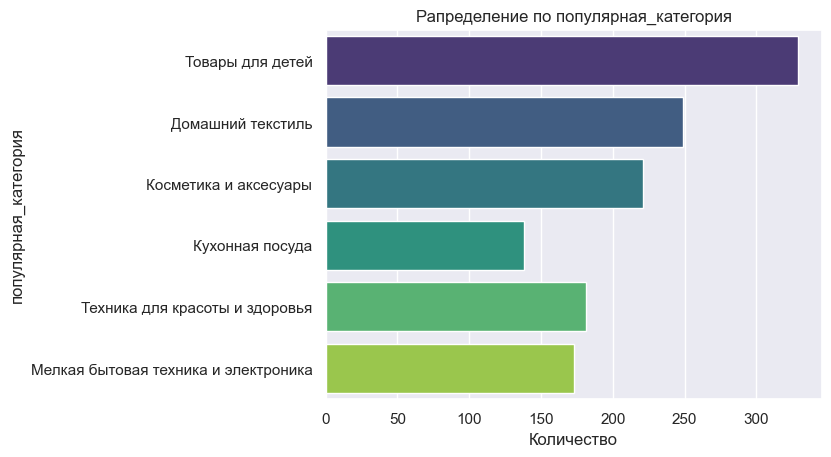

In [103]:
sns.countplot(y='популярная_категория', data=df, palette='viridis')
plt.title(f'Рапределение по {'популярная_категория'}')
plt.xlabel('Количество')
plt.show()

## Построим график и посмотрим, покупатели какой категории чаще всего делаю акционные покупки.

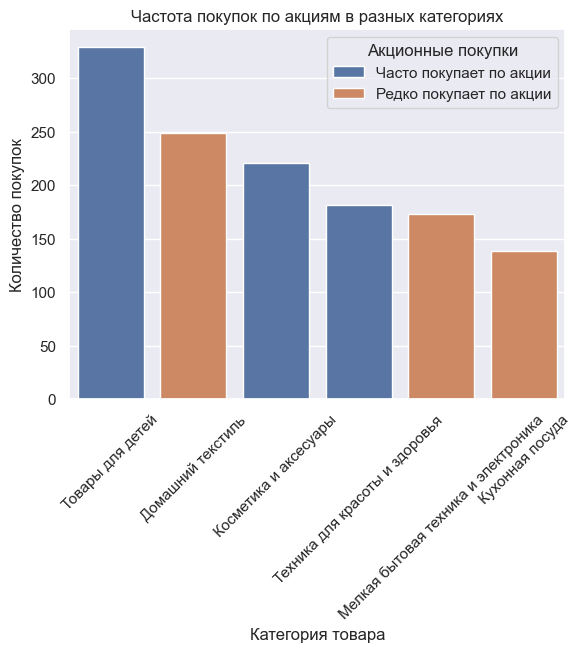

In [104]:
plot_data = df["популярная_категория"].value_counts().reset_index()
plot_data.columns = ["категория", "количество"]

sns.barplot(data=plot_data, x="категория", y="количество", hue=df["акционные_покупки_категория"])
plt.title("Частота покупок по акциям в разных категориях")
plt.xlabel("Категория товара")
plt.ylabel("Количество покупок")
plt.legend(title="Акционные покупки")
plt.xticks(rotation=45)
plt.show()

## Как и ожидалось - это клиенты, которые покупают товары для детей. По всей видимости они ищут самую пивлекательную цену для расходников в виде памперсов, питания и т.д.
Остальные категории товаров реже покупаются по акции, как мне кажется потому что покупатели в первую очередь смотрят на то, как впишется в интерьер текстиль, техника, аксессуары, кухонная посуда 

In [105]:
df['сегмент'] = df.apply(
    lambda x: 'Исследуемый сегмент' 
    if x['вероятность_снижения'] > 0.8 
    and x['акционные_покупки_категория']=='Часто покупает по акции' 
    else 'Остальные пользователи', 
    axis=1
    )

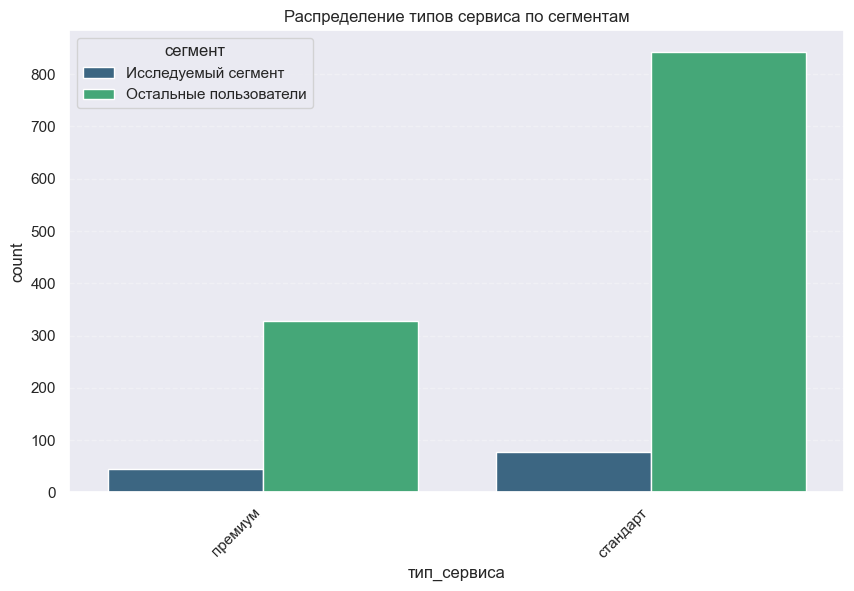

In [106]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='тип_сервиса',
    hue='сегмент',
    palette='viridis'
)
plt.title('Распределение типов сервиса по сегментам')
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

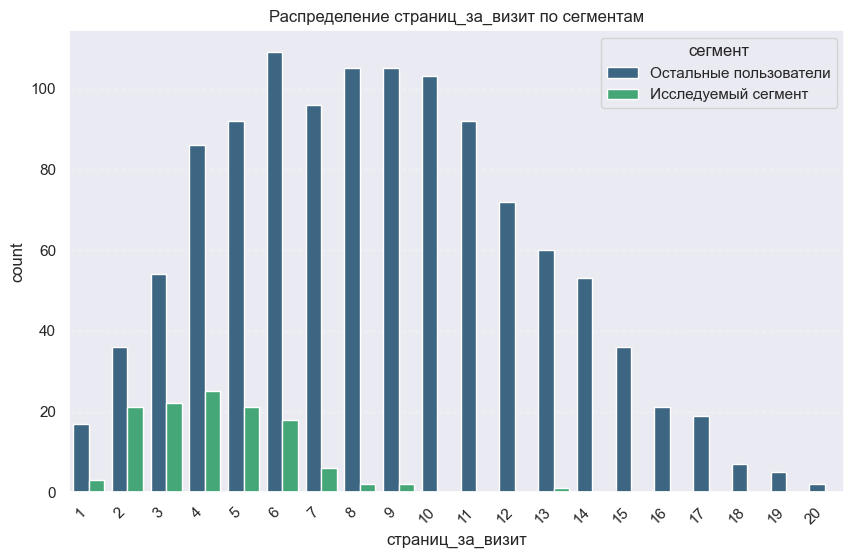

In [107]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='страниц_за_визит',
    hue='сегмент',
    palette='viridis'
)
plt.title('Распределение страниц_за_визит по сегментам')
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

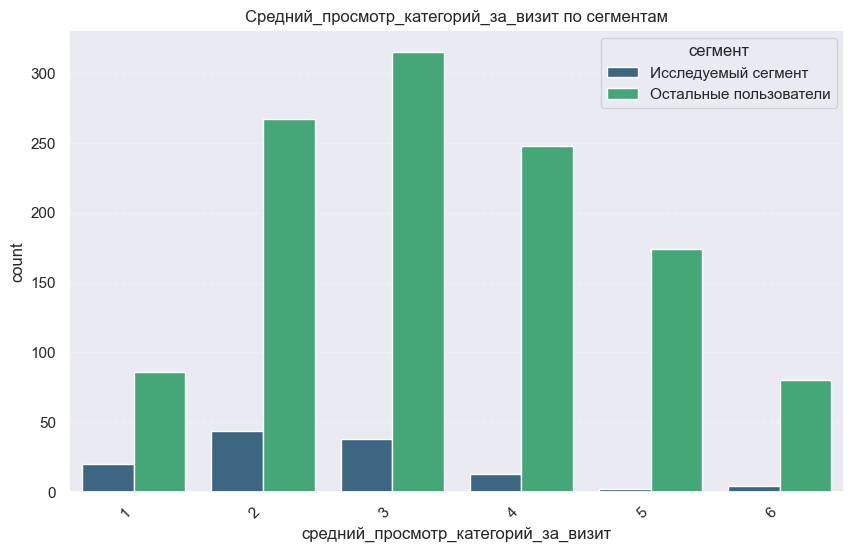

In [108]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='средний_просмотр_категорий_за_визит',
    hue='сегмент',
    palette='viridis'
)
plt.title('Средний_просмотр_категорий_за_визит по сегментам')
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

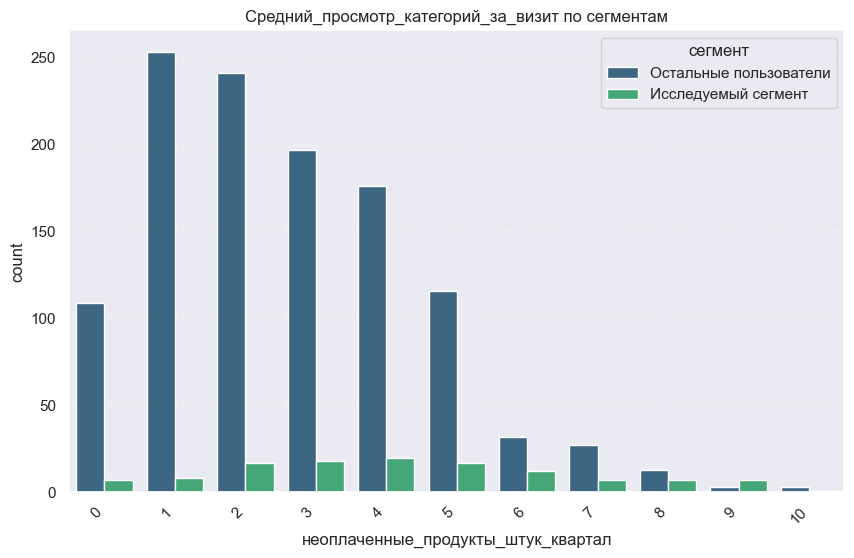

In [109]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='неоплаченные_продукты_штук_квартал',
    hue='сегмент',
    palette='viridis'
)
plt.title('Средний_просмотр_категорий_за_визит по сегментам')
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

Рассмотрели некоторые признаки сегмента пользователей, которые покупают по скидке и имеют высокую вероятность снижения покупательской активности.
Данные клиенты быстро проверяют интересующие их категории на предмет наличия акции, если не находят выгодное предложение, уходят дальше искать выгодное предложение.   
Для данного сегмента нужна определнная рассылка с скидками на интересующие их категории товаров.   
Также сделать так, чтобы на главное странице сразу отображались товары по акции из нужной категории.   

# Вывод
### Было выполнено 2 задачи:   
- Построение модели для предсказания снижения покупательской активности в интернет магазине "В один клик".   
- Выделение сегмента из клиентов и его иследование.   

### Выполненные шаги:   

1. Загрузка данных.   

2. Предобработка данных:   
- изменил в некоторых стоблцах тип данных с строкового, на числовой;   
- исправлены дубликаты, которые появились из-за опечатки 'стандартт', 'стандарт'.   

3. Исследовательский анализ данных:   
- на данном этапе было замечено аномальное значение прибыли - id клиента = 215380, выручка = 106862.2

4. Корреляционный анализ данных: 
Целевым признаком является Покупательская_активность он коррелирует сильнее всего с такими признаками: 
- Маркет_актив_6_мес,    
- Акционные_покупки,    
- Средний_просмотр_категорий_за_визит,    
- Неоплаченные_продукты_штук_квартал,    
- Страниц_за_визит,    
- Выручка_препредыдущий_месяц,   
- минут_предыдущий_месяц,    
- минут_текущий_месяц.   

5. Объеденение таблиц
Датасеты: 
- market_file,    
- market_money,     
- market_time.   

6. Обучение модели    
С использованием пайпланов из библиотеки sklearn были обучены модели:    
- DecisionTreeClassifier(),    
- KNeighborsClassifier(),    
- SVC(),   
- LogisticRegression().    
При обучении моделей были подобраны лучшие гиперпараметры.   
По результатам обучения лучшей стала модель LogisticRegression(C=1, penalty='l1', random_state=1131, solver='liblinear'))]).    
Метрика roc_auc для тренеровочной выборки 0.91 для тестовой 0.886.   

7. Анализ важности признаков
### Топ 7 самых важных признаков:   
- Страниц_за_визит, 
- минут в предыдущий месяц,
- Средний просмотр категорий за визит, 
- Неоплаченный_продукты_штук_квартал, 
- минут текущий месяц,
- часто покупает по акции, 
- мелкая бытовая техника и электроника.

Чем больше пролистаешь страниц те больше вероятность что найдешь нужный товар. Кроме того при поиске той самой модели продукта постоянно добавляешь в корзину интересные находки и в итоге покупаешь только что-то одно.
Объяснить это можно, как просмотр reels или tik-tok. Чем дольше проводишь времени и смотришь на яркие вещи, тем больше начинаешь листать в поисках новой, неординарной вещи.

### Малозначимыми признаками оказались:
- Популярная категория(кроме бытовой техники), 
- Маркет_актив_тек_мес, 
- Разрешить сообщать, 
- Тип_сервиса, 
- Выручка_текущий_месяц, 
- Длительность, 
- Ошибка_сервиса, 
- Выручка_предыдущий_месяц. 

8. Сегментация пользователей.   
Для анализа пользователей был выбран сегмент пользователей часто покупающих по скидке и в то же время имеющийх высокую вероятность снижения покупательской активности. Был выделен сегмент, который часто покупает по скидке товары для детей. 

## Рекомендации:
- Акцентировать внимание над рекомендательной системой, чтобы даже в том случае, когда клиент просмотрит все товары, которые он искал, лента продолжалась. Превратить поиск нужного товара в скролл подольше.
- Для увеличения актвности этого сегмента покупателей надо настроить главную страницу так, чтобы на ней сразу были интересующие товары по акции. Данный сегмент пользователей долго не засиживается на одном сайте и как только не находит выгодное предложение, сразу уходит на другие сайты. Они не хотят тратить время на поиски и очень мало просматривают страниц, однако они всегда ищут определенную категорию товаров - Товары для детей.    